# Counterfactuals Model 2

In [79]:
import pandas as pd
import numpy as np
import xgboost
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from joblib import Parallel, delayed

In [80]:
modeling_df = pd.read_parquet('../data/cdc_scraper/counterfactual_modeling_df.parquet')

In [81]:
modeling_vars = ['unemployment_rate_2020',
'median_household_income_2019',
'poverty_frac_2019',
'no_high_school',
'high_school_only',
'college_only',
'voted_biden',
'percent_hispanic',
'percent_non_hispanic_black',
'percent_non_hispanic_white',
'face_masks_required_in_public_Public mask mandate',
'moving_cases_lag_1',
'moving_cases_lag_2',
'moving_cases_lag_3',
'moving_cases_lag_4',
'moving_cases_lag_5',
'moving_cases_lag_6',
'estimated_hesitant',
'estimated_strongly_hesitant',
'pct_fully_vaccinated',
'weekday_0',
'weekday_1',
'weekday_2',
'weekday_3',
'weekday_4',
'weekday_5',
'weekday_6',
'year_2020',
'year_2021',
'year_2022',
'month_1',
'month_10',
'month_11',
'month_12',
'month_2',
'month_3',
'month_4',
'month_5',
'month_6',
'month_7',
'month_8',
'month_9'
]

# Model Tuning: No Masks

In [82]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error

In [83]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgboost.XGBRegressor(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    #evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X, y,
            #eval_set=evaluation,
            verbose=False)
    

    pred = clf.predict(X)
    accuracy = mean_squared_error(y,pred)
    print ("SCORE:", accuracy)
    return {'loss': accuracy, 'status': STATUS_OK }

In [123]:
def tune_model(df,masks,params,n_sample=1000):
    sample_df = df[df['face_masks_required_in_public_Public mask mandate']==masks].sample(n_sample)
    X = sample_df[modeling_vars]
    y = sample_df['moving_cases_per_100k']
    
    def objective(space):
        clf=xgboost.XGBRegressor(
                        n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                        reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                        colsample_bytree=int(space['colsample_bytree']))

        #evaluation = [( X_train, y_train), ( X_test, y_test)]

        clf.fit(X, y,
                #eval_set=evaluation,
                verbose=False)


        pred = clf.predict(X)
        accuracy = mean_squared_error(y,pred)
        print ("SCORE:", accuracy)
        return {'loss': accuracy, 'status': STATUS_OK }
    
    trials = Trials()
    best_hyperparams = fmin(fn = objective,
                            space = space,
                            algo = tpe.suggest,
                            max_evals = 20,
                            trials = trials)
    
    print(best_hyperparams)
    
    colsample_bytree = best_hyperparams['colsample_bytree']
    gamma = best_hyperparams['gamma']
    max_depth = int(best_hyperparams['max_depth'])
    min_child_weight = int(best_hyperparams['min_child_weight'])
    reg_alpha = best_hyperparams['reg_alpha']
    reg_lambda = best_hyperparams['reg_lambda']
    
    model = xgboost.XGBRegressor(
        colsample_bytree= colsample_bytree,
        gamma=gamma,
        max_depth= max_depth,
        min_child_weight= min_child_weight,
        reg_alpha= reg_alpha,
        reg_lambda= reg_lambda
    ).fit(X, y)
    return model
     
    

In [131]:
model1 = tune_model(modeling_df,masks=1,params=space,n_sample=500000)
model2 = tune_model(modeling_df,masks=0,params=space,n_sample=500000)



  0%|                                                                                                                                                                | 0/20 [00:00<?, ?trial/s, best loss=?]

                                                                                                                                                                                                      SCORE:


  0%|                                                                                                                                                                | 0/20 [00:22<?, ?trial/s, best loss=?]

                                                                                                                                                                                                      233.67074400417798


  0%|                                                                                                                                                           

## RUN Models

In [132]:
def run_forward_mask(df,model):
    df['change_points']= np.where(df['face_masks_required_in_public_No public mask mandate']!=df['face_masks_required_in_public_No public mask mandate'].shift(1).bfill(),1,0)
    change_imd =df.index.get_loc(df.index[df['change_points'] == 1][0])
    dates = df.iloc[change_imd:,5].unique()
    preds = []
    all_dfs = []
    for i, date in enumerate(dates):
        xx = df[df['date']==date].copy()
        if i ==0:

            preds.append(model.predict(xx[modeling_vars])[0])

            current = model.predict(xx[modeling_vars])[0]
            delta_1 = xx['moving_cases_lag_1'].values[0]
            delta_2 = xx['moving_cases_lag_2'].values[0]
            delta_3 = xx['moving_cases_lag_3'].values[0]
            delta_4 = xx['moving_cases_lag_4'].values[0]
            delta_5 = xx['moving_cases_lag_4'].values[0]
        else:
            xx['moving_cases_lag_1'] = preds[i-1]
            xx['moving_cases_lag_2'] = delta_1
            xx['moving_cases_lag_3'] = delta_2
            xx['moving_cases_lag_4'] = delta_3
            xx['moving_cases_lag_5'] = delta_4
            xx['moving_cases_lag_6'] = delta_5


            preds.append(model.predict(xx[modeling_vars])[0])

            current = model.predict(xx[modeling_vars])[0]
            delta_1 = xx['moving_cases_lag_1'].values[0]
            delta_2 = xx['moving_cases_lag_2'].values[0]
            delta_3 = xx['moving_cases_lag_3'].values[0]
            delta_4 = xx['moving_cases_lag_4'].values[0]
            delta_5 = xx['moving_cases_lag_5'].values[0]
    results_df = pd.DataFrame({'date':dates,'mask_requirement' : preds})
    return results_df

def run_forward_no_mask(df,model):
    df['change_points']= np.where(df['face_masks_required_in_public_No public mask mandate']!=df['face_masks_required_in_public_No public mask mandate'].shift(1).bfill(),1,0)
    change_imd =df.index.get_loc(df.index[df['change_points'] == 1][0])
    dates = df.iloc[change_imd:,5].unique()
    preds = []
    all_dfs = []
    for i, date in enumerate(dates):
        xx = df[df['date']==date].copy()
        if i ==0:

            preds.append(model.predict(xx[modeling_vars])[0])

            current = model.predict(xx[modeling_vars])[0]
            delta_1 = xx['moving_cases_lag_1'].values[0]
            delta_2 = xx['moving_cases_lag_2'].values[0]
            delta_3 = xx['moving_cases_lag_3'].values[0]
            delta_4 = xx['moving_cases_lag_4'].values[0]
            delta_5 = xx['moving_cases_lag_4'].values[0]
        else:
            xx['moving_cases_lag_1'] = preds[i-1]
            xx['moving_cases_lag_2'] = delta_1
            xx['moving_cases_lag_3'] = delta_2
            xx['moving_cases_lag_4'] = delta_3
            xx['moving_cases_lag_5'] = delta_4
            xx['moving_cases_lag_6'] = delta_5


            preds.append(model.predict(xx[modeling_vars])[0])

            current = model.predict(xx[modeling_vars])[0]
            delta_1 = xx['moving_cases_lag_1'].values[0]
            delta_2 = xx['moving_cases_lag_2'].values[0]
            delta_3 = xx['moving_cases_lag_3'].values[0]
            delta_4 = xx['moving_cases_lag_4'].values[0]
            delta_5 = xx['moving_cases_lag_5'].values[0]
    results_df = pd.DataFrame({'date':dates,'no_mask_requirement' : preds})
    return results_df
    
def run_for_fips(df,fips_code_text):
    try:
        df = df[df['fips_code_text']==fips_code_text].copy()
        mask_preds = run_forward_mask(df,model1)
        no_mask_preds = run_forward_no_mask(df,model2)
        melted_df = mask_preds.merge(no_mask_preds).melt(id_vars='date')
        melted_df['fips_code_text'] = fips_code_text
        return melted_df
    except:
        pass

In [138]:
%%time
all_runs_list = Parallel(n_jobs=6)(delayed(run_for_fips)(modeling_df,i) for i in tqdm(modeling_df['fips_code_text'].unique()))



  0%|                                                                                                                                                                              | 0/2832 [00:00<?, ?it/s]

  0%|▋                                                                                                                                                                    | 12/2832 [00:05<21:42,  2.16it/s]

  1%|█                                                                                                                                                                    | 18/2832 [00:18<55:44,  1.19s/it]

  1%|█▍                                                                                                                                                                 | 24/2832 [00:28<1:02:01,  1.33s/it]

  1%|█▋                                                                                                                                                                 | 30/2

CPU times: user 32min 45s, sys: 9min, total: 41min 46s
Wall time: 58min 36s


In [135]:
from plotnine import *

In [147]:
all_runs = pd.concat(all_runs_list).merge(modeling_df[['fips_code_text','state_code']].drop_duplicates())
state_counterfactuals = all_runs.groupby(['date','variable','state_code']).agg({'value':'sum'}).reset_index()
state_actuals = modeling_df.groupby(['date','state_code']).agg({'moving_cases_per_100k':'sum'}).reset_index()
state_actuals.columns = ['date','state_code','value']
state_actuals['variable'] = 'actual'
final_results = pd.concat([state_counterfactuals,state_actuals[['date','variable','state_code','value']]])

In [171]:
final_results.to_csv('counterfactual_results_model_2.csv',index=False)

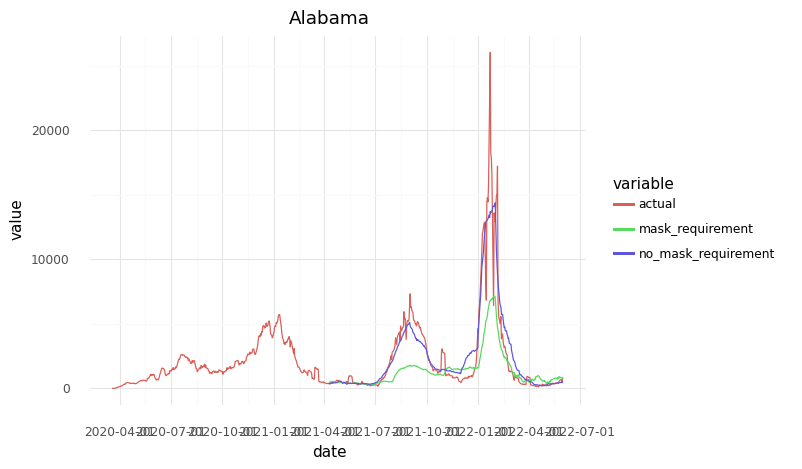

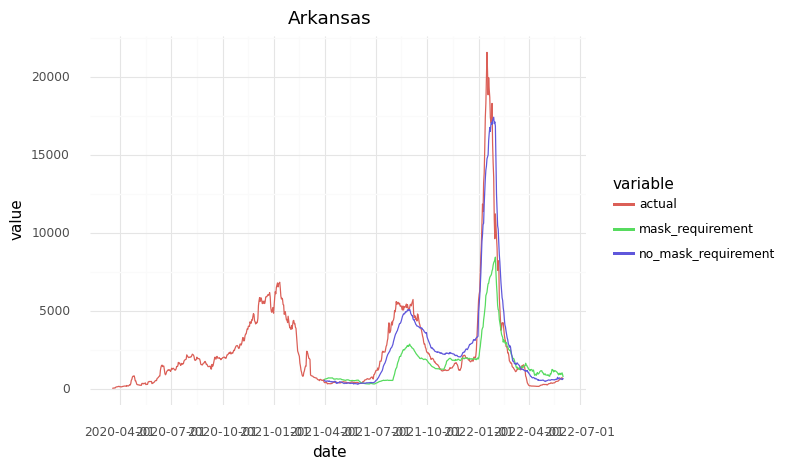

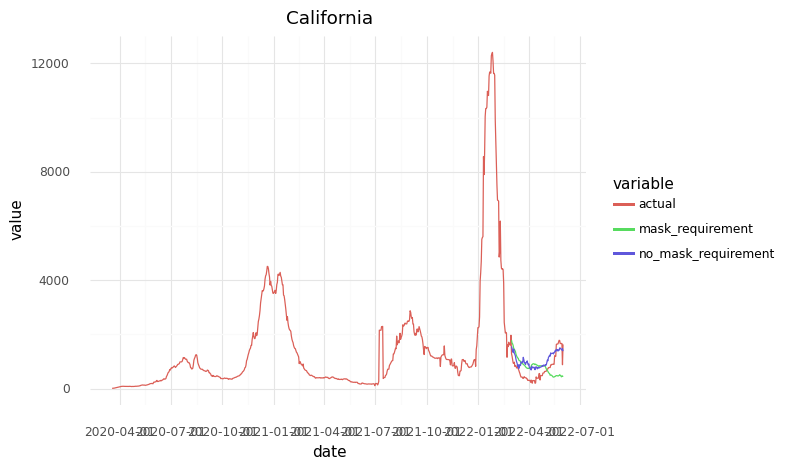

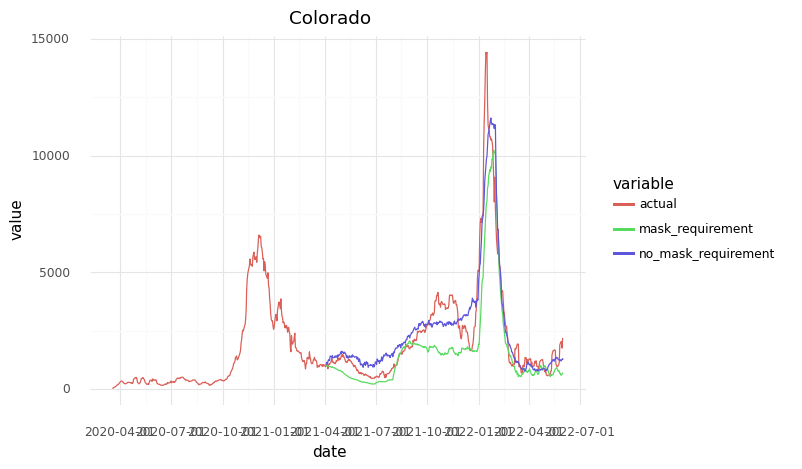

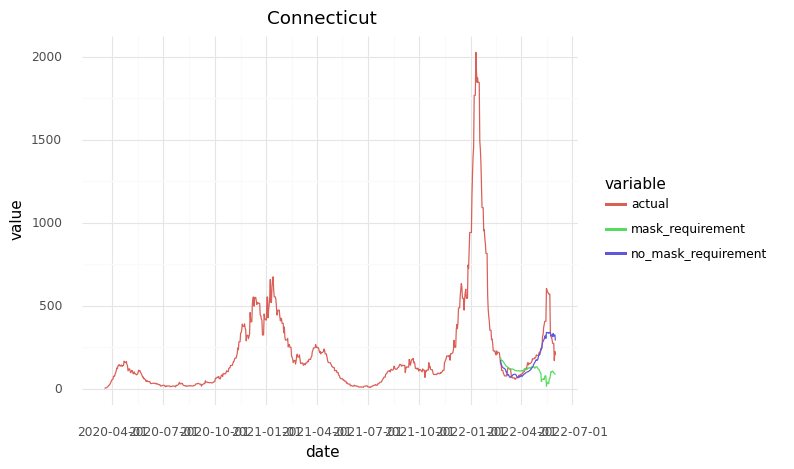

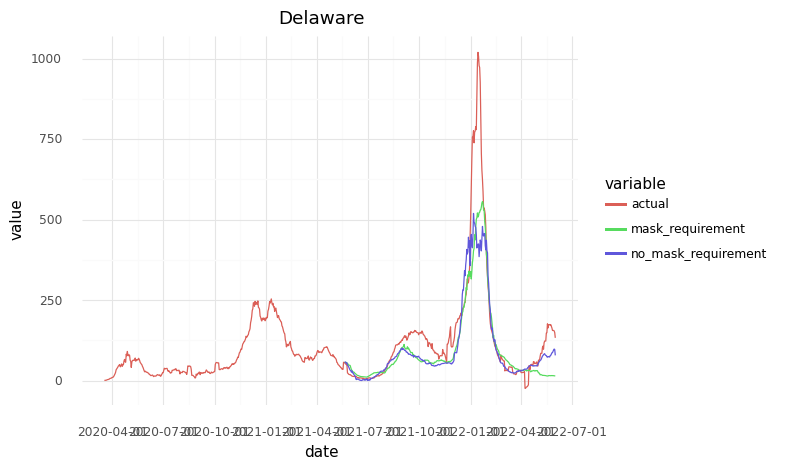

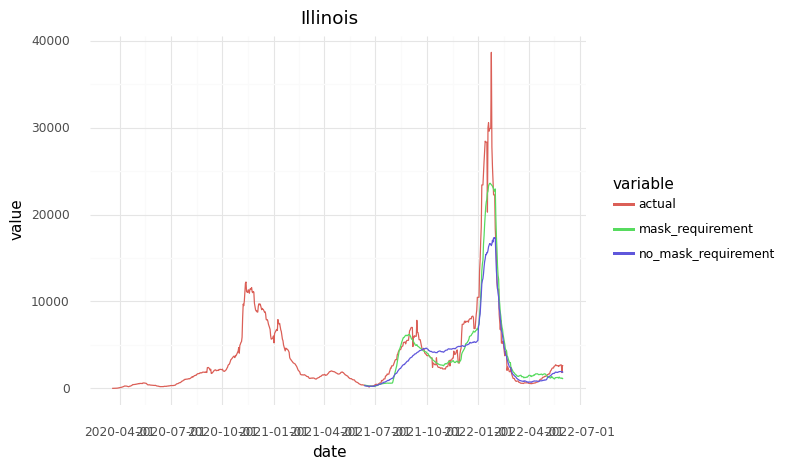

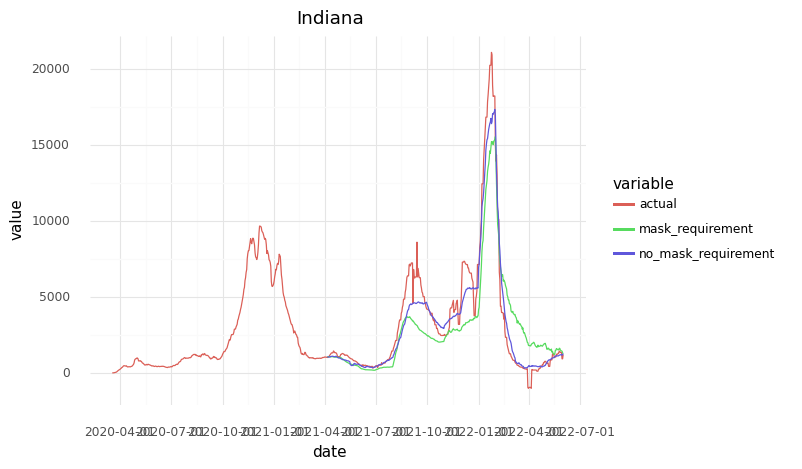

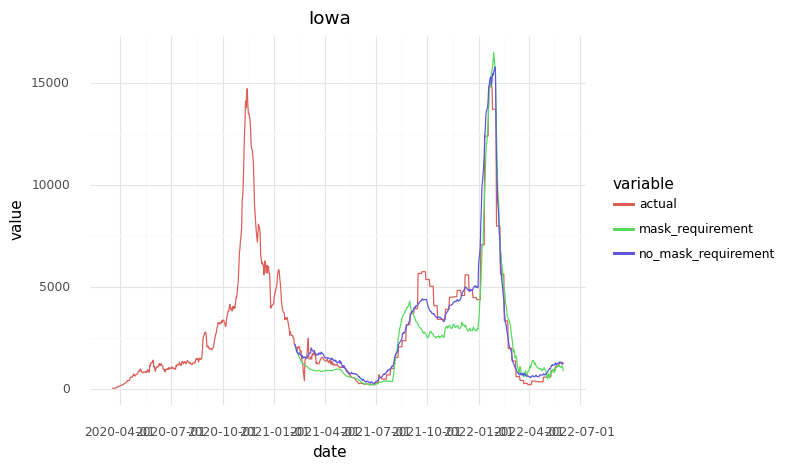

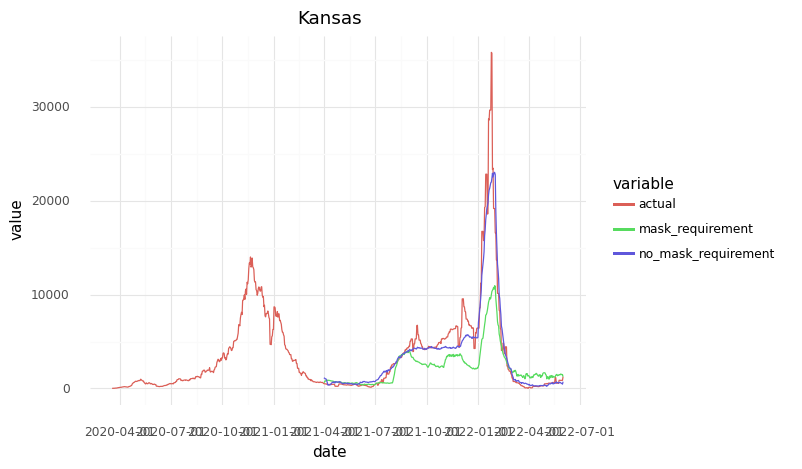

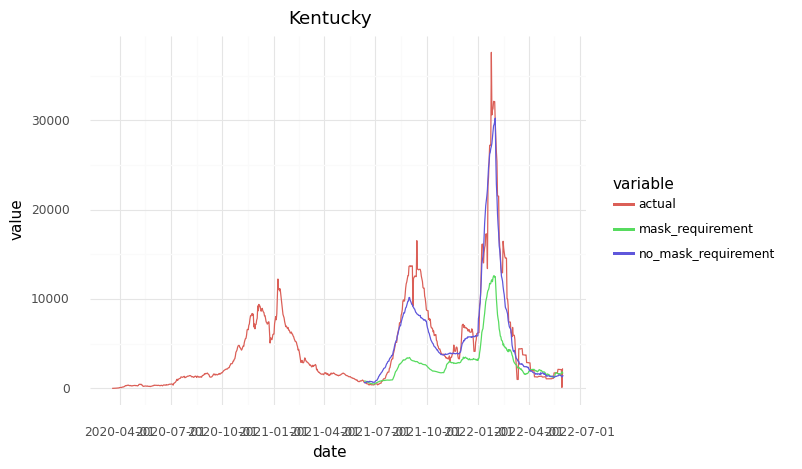

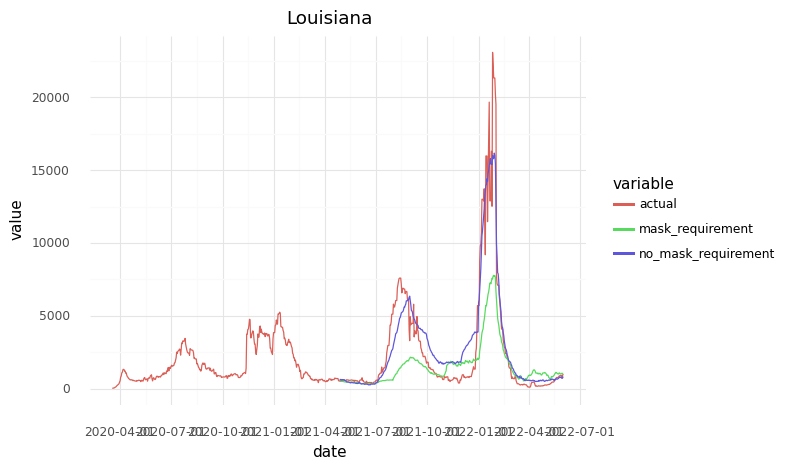

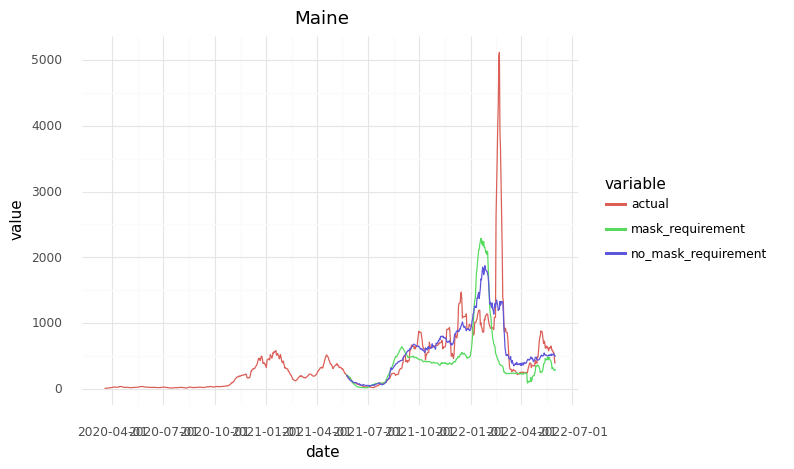

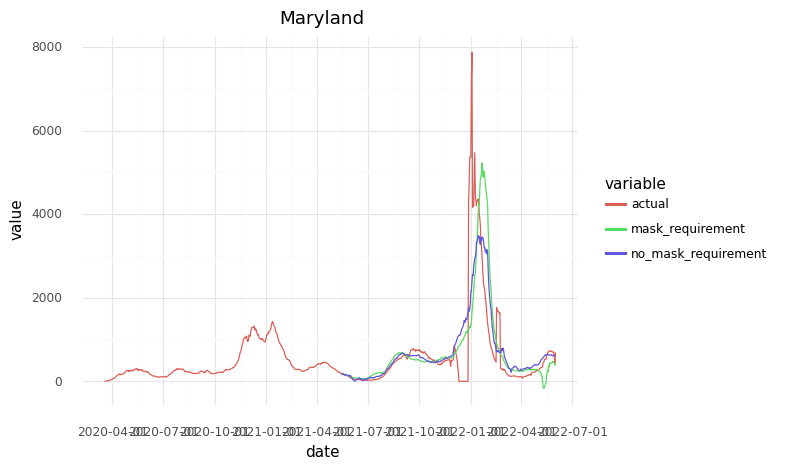

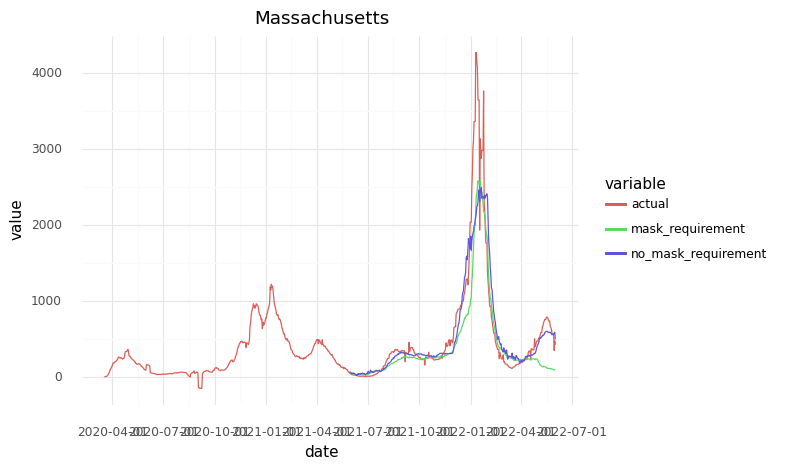

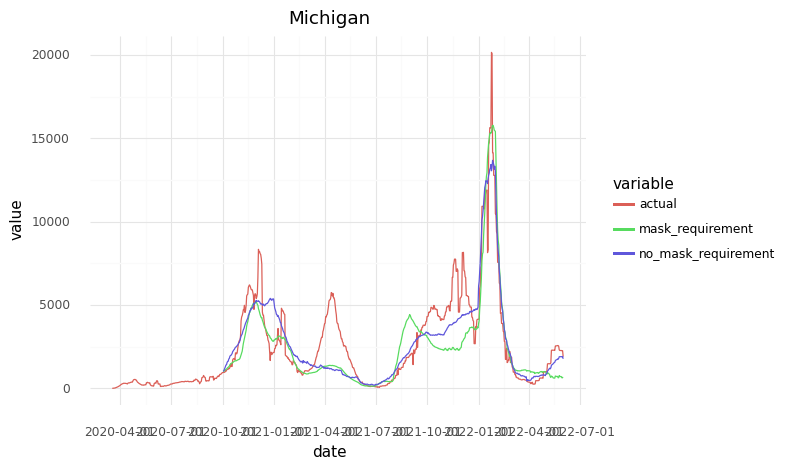

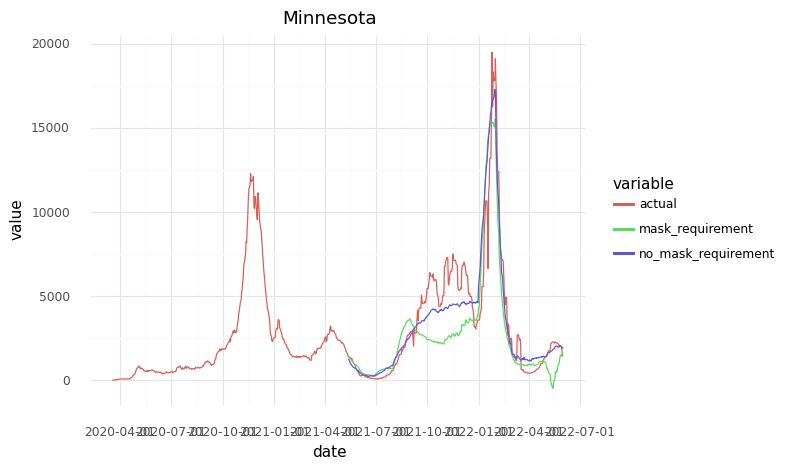

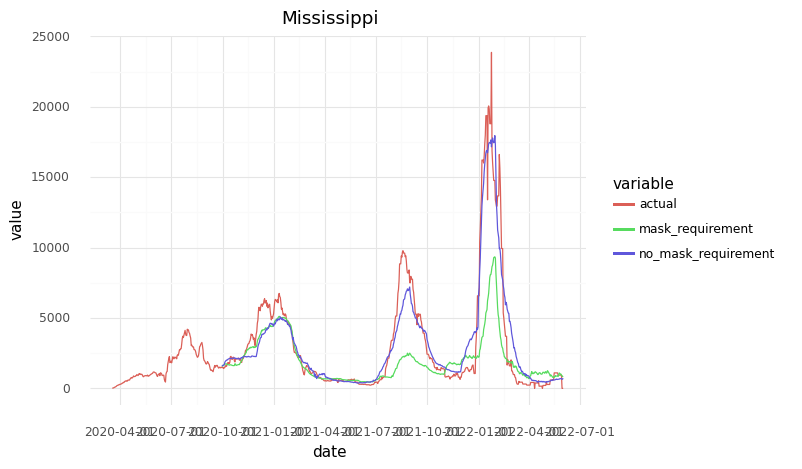

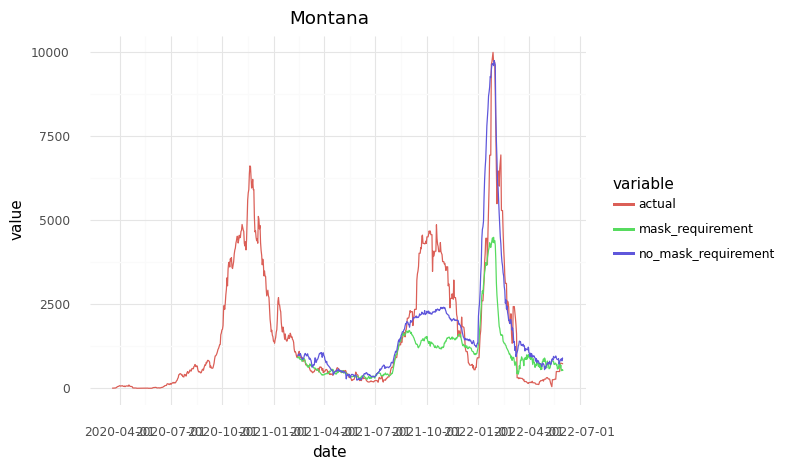

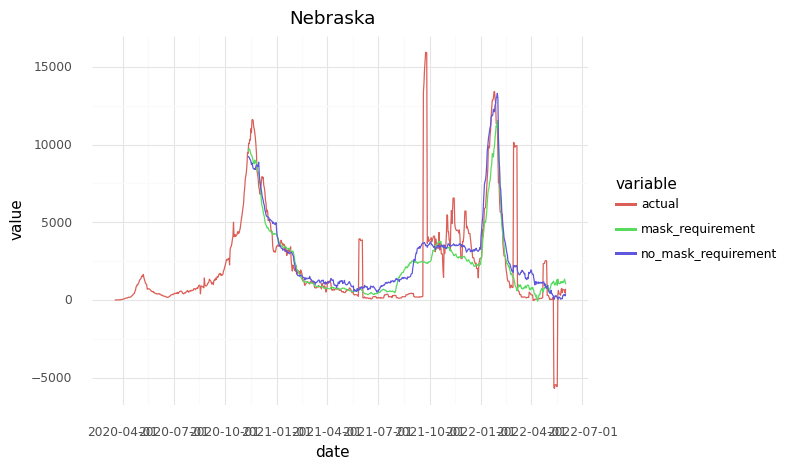

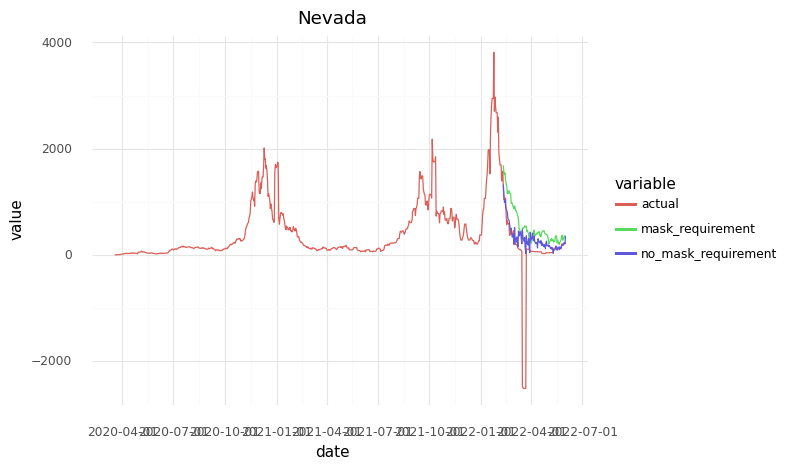

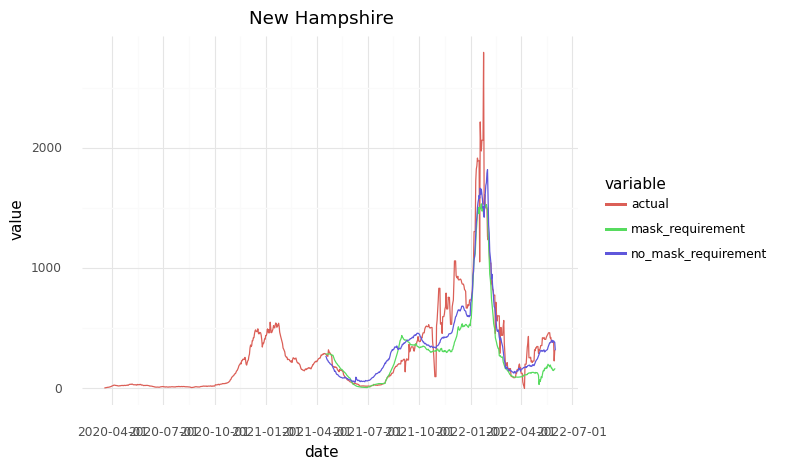

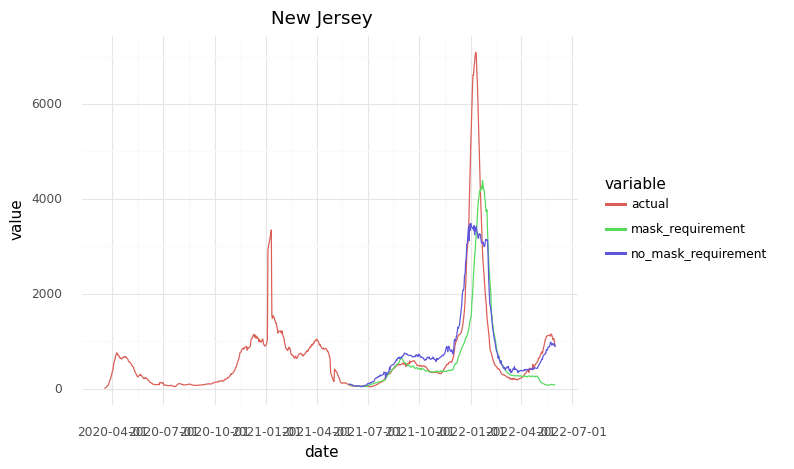

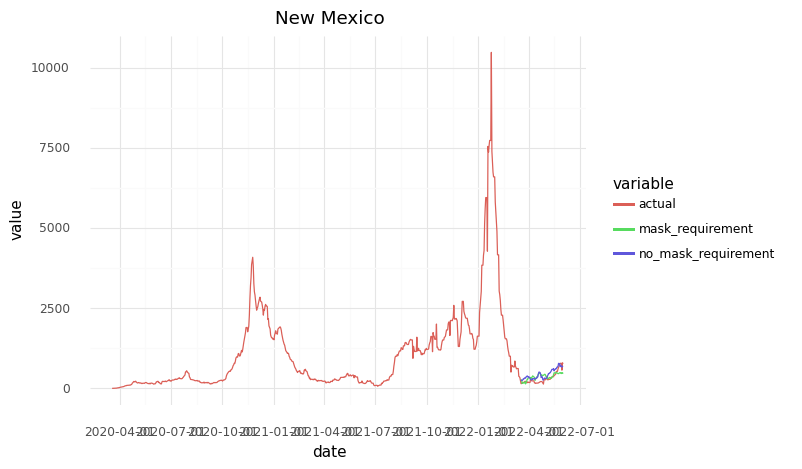

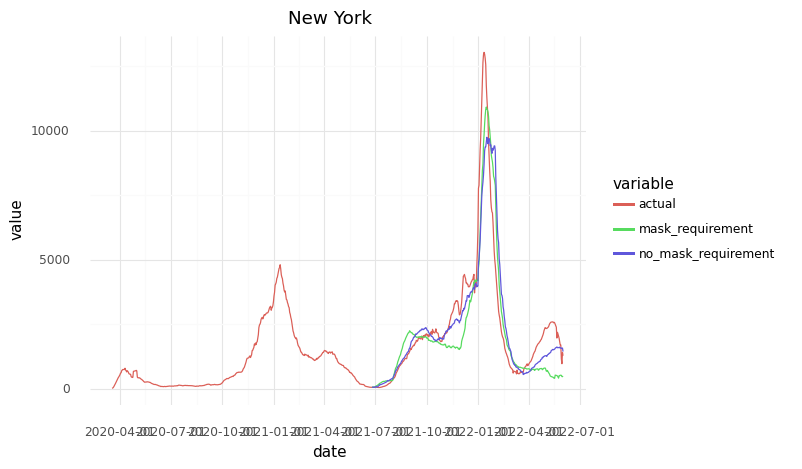

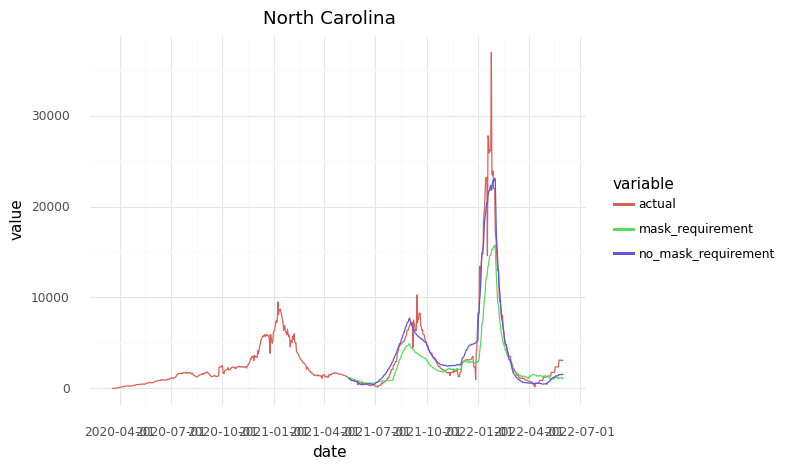

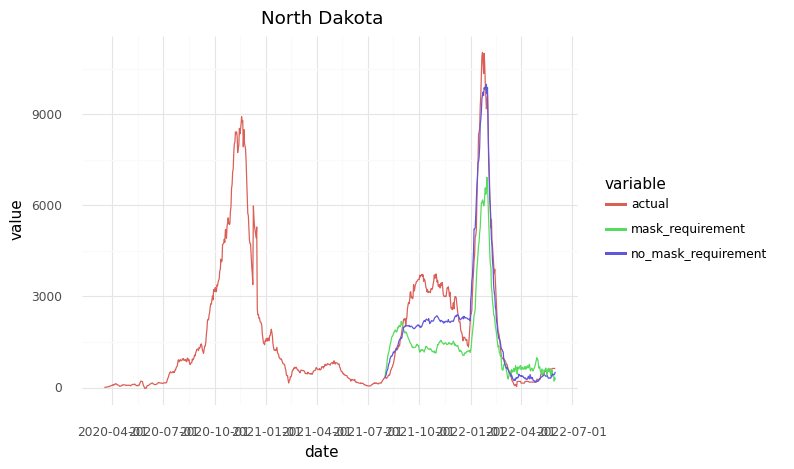

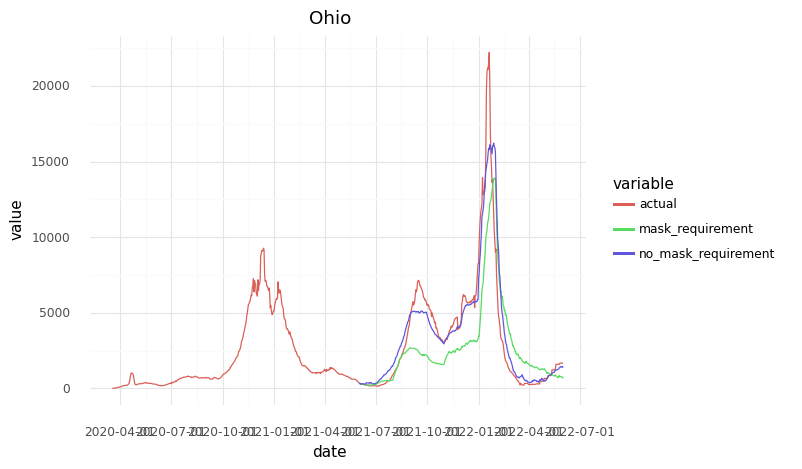

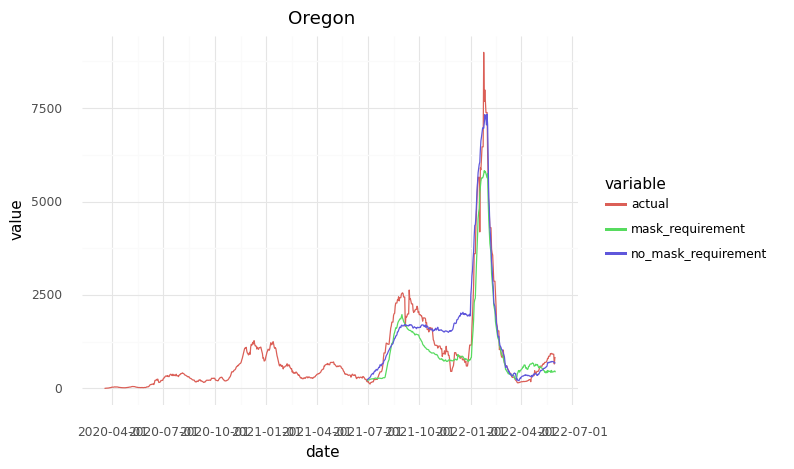

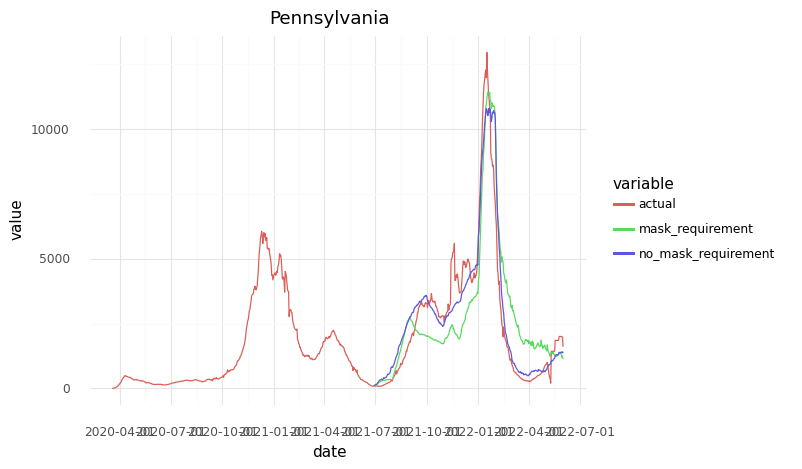

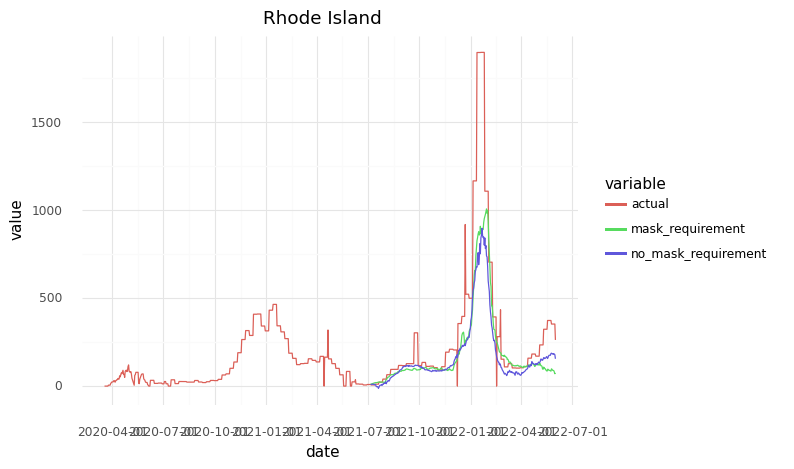

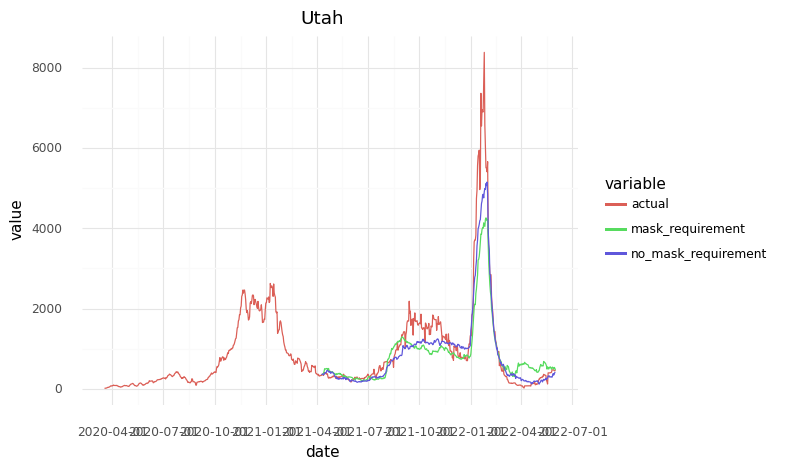

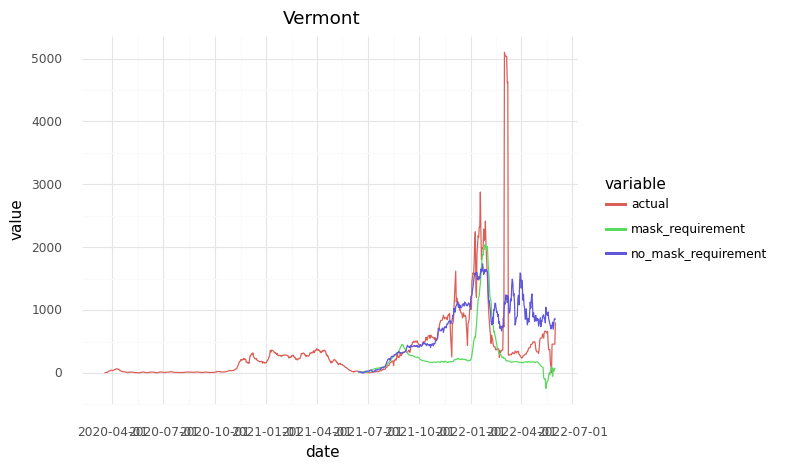

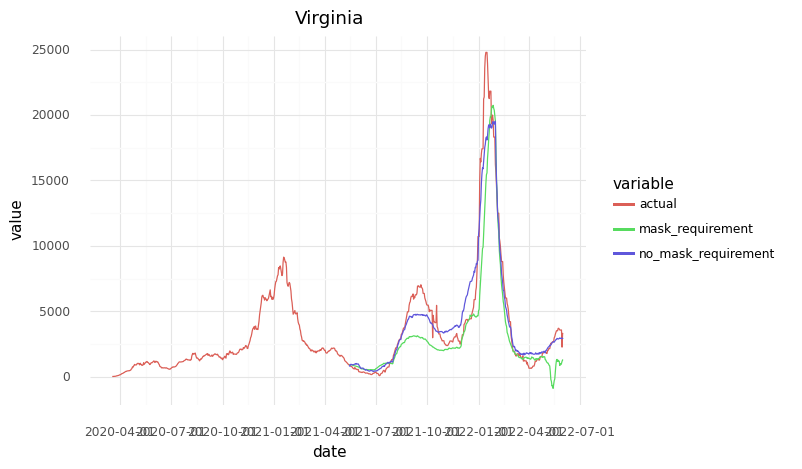

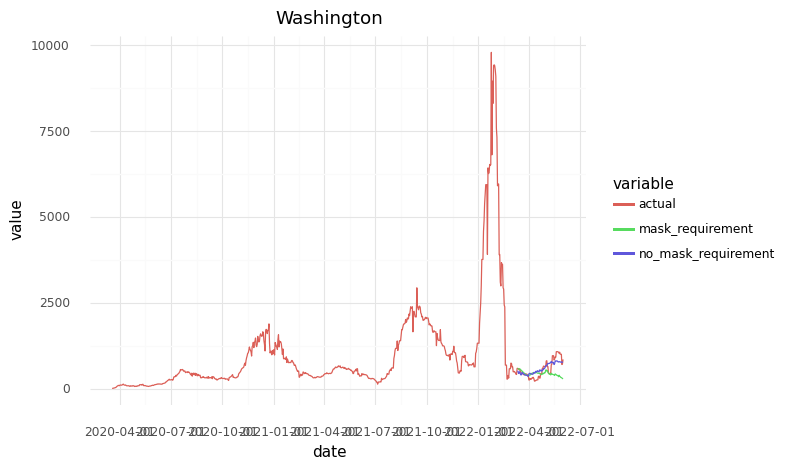

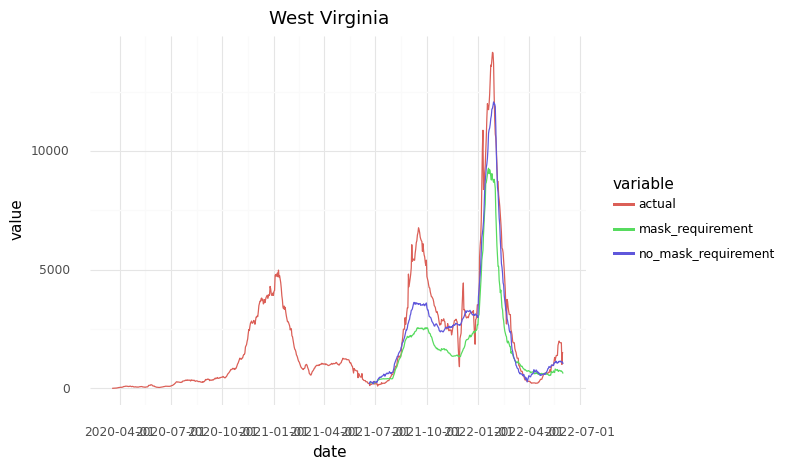

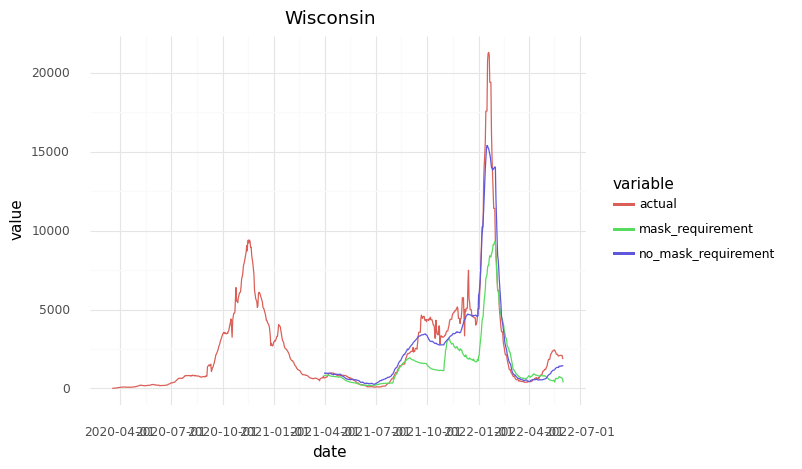

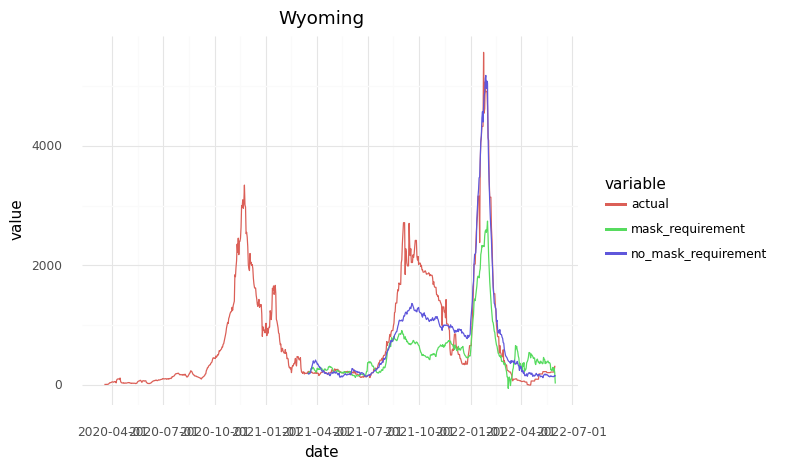

In [168]:
for state in sorted(final_results['state_code'].unique()):
    print(ggplot(final_results[final_results['state_code']==state],aes('date','value',color='variable')) + geom_line() + theme_minimal() + ggtitle(state))